In [2]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [3]:
# Libraries To Use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
from datetime import datetime,time,date
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os 
import h5py
import talib

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *
from SingleFactorTest.calcOwnFactors import CalOwnFactor

In [6]:
%load_ext line_profiler

In [7]:
%matplotlib inline

In [8]:
path = ff.data_path # path

In [9]:
# Constants
startTime =  datetime.strptime('20120104', '%Y%m%d')
endTime = datetime.strptime('20170928', '%Y%m%d')

In [6]:
# --------------------------------------- Global Functions to def---------------------------------- #

In [ ]:
# --------------------------------------- neutralize class ---------------------------------- #

In [10]:
class neutralize(CalOwnFactor):
    classname = 'neutralize'
    
    def __init__(self, path,filenameFCAP,factorData):
        super(neutralize,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        self.logFCAP = np.log10(ff.readh5data(path,filenameFCAP))
        self.factorData = factorData
        
    def simpleNormalize(self,factorData):
        factorDatatemp = factorData.copy()
        dataWinsorizedTrans = factorDatatemp.T
        MAD = 1.483*np.abs(dataWinsorizedTrans-dataWinsorizedTrans.median(skipna=True))
        return ((dataWinsorizedTrans - dataWinsorizedTrans.mean(axis=0, skipna=True))/\
                               dataWinsorizedTrans.std(axis=0, skipna=True)).T
    def neutralizeFactor(self, datelist):
        normalizedLFCAPDF = self.simpleNormalize(self.logFCAP)
        normalizedFactor= self.simpleNormalize(self.factorData)
        factorNeutralized = pd.DataFrame(index=normalizedFactor.index, columns=normalizedFactor.columns, data=None, dtype = float)
        for date in datelist:
            LFCAPIndice = normalizedLFCAPDF.loc[date].dropna()
            factorIndice = normalizedFactor.loc[date].dropna()
            intersectionStocks = list(set(LFCAPIndice.index) & set(factorIndice.index))
            #dummy_Matrix = pd.get_dummies(IndustryDF.loc[date]).T.iloc[:-1]
            #dummy_Matrix = dummy_Matrix[intersectionStocks].append(LFCAPIndice.loc[intersectionStocks])
            try:
                result = sm. OLS(factorIndice.loc[intersectionStocks].T, LFCAPIndice.loc[intersectionStocks].T).fit()
                factorNeutralized.loc[date][intersectionStocks] = result.resid
            except:
                factorNeutralized.loc[date] = np.NaN
        self.factorNeutralized = factorNeutralized.round(4)

In [12]:
# top functions to def
def simpleNormalize(narrowedData):
    dataWinsorized = narrowedData.copy()
    dataWinsorizedTrans = dataWinsorized.T
    MAD = 1.483*np.abs(dataWinsorizedTrans-dataWinsorizedTrans.median(skipna=True))
    return ((dataWinsorizedTrans - dataWinsorizedTrans.mean(axis=0, skipna=True))/dataWinsorizedTrans.std(axis=0, skipna=True)).T

In [13]:
# top function
def neutralizeFactor(normalizedFactorDF, normalizedLFCAPDF, datelist):
    factorNeutralized = pd.DataFrame(index=normalizedFactorDF.index, columns=normalizedFactorDF.columns, data=None, dtype = float)
    for date in datelist:
        LFCAPIndice = normalizedLFCAPDF.loc[date].dropna()
        factorIndice = normalizedFactorDF.loc[date].dropna()
        intersectionStocks = list(set(LFCAPIndice.index) & set(factorIndice.index))
        #dummy_Matrix = pd.get_dummies(IndustryDF.loc[date]).T.iloc[:-1]
        #dummy_Matrix = dummy_Matrix[intersectionStocks].append(LFCAPIndice.loc[intersectionStocks])
        try:
            result = sm. OLS(factorIndice.loc[intersectionStocks].T, LFCAPIndice.loc[intersectionStocks].T).fit()
            factorNeutralized.loc[date][intersectionStocks] = result.resid
        except:
            factorNeutralized.loc[date] = np.NaN
    return factorNeutralized

In [9]:
# --------------------------------------- Function Section End ---------------------------------- #

In [ ]:
filenameFCAP =  'LZ_CN_STKA_VAL_A_FCAP.h5'
# Data prepared for Neuralization
FCAP1 = np.log10(ff.readh5data(path,filenameFCAP))
NormalizedFCAP = simpleNormalize(FCAP1)

In [ ]:
# --------------------------------------- AdjustedPrice ---------------------------------- #

In [155]:
filenameAdjustFactor = 'LZ_CN_STKA_CMFTR_CUM_FACTOR.h5'
filenameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5'
filenameOpen =  'LZ_CN_STKA_QUOTE_TOPEN.h5'

In [152]:
# first thing is to calculate forward adjusted pice
class AdjustedPrice(CalOwnFactor):
    classname = 'AdjustedPrice'
    def __init__(self,path):
        super(AdjustedPrice,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calAdjustedPrice(self,adjFacBackward,originalPrice):
        AdjFacforward = adjFacBackward / adjFacBackward.iloc[-1]
        self.adjustedPrice = (AdjFacforward * originalPrice).round(3)     

In [153]:
# 前复权收盘价
adjc = AdjustedPrice(path)
adjc.addData('adjf',filenameAdjustFactor)
adjc.addData('close',filenameClose)
adjc.calAdjustedPrice(adjc.datadict['adjf'],adjc.datadict['close'])
adjc.saveData(adjc.adjustedPrice,'OwnfactorAdjustedClose')

c:\python27\lib\site-packages\pandas\core\series.py:1295: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


In [156]:
# 前复权开盘价
adjo = AdjustedPrice(path)
adjc.addData('adjf',filenameAdjustFactor)
adjc.addData('open',filenameOpen)
adjc.calAdjustedPrice(adjc.datadict['adjf'],adjc.datadict['open'])
adjc.saveData(adjc.adjustedPrice,'OwnfactorAdjustedOpen')

In [ ]:
# --------------------------------------- end  AdjustedPrice section ---------------------------------- #

In [12]:
# --------------------------------------- Mass Index ---------------------------------- #

In [71]:
filenameOpen = 'LZ_CN_STKA_QUOTE_TOPEN.h5' # 开盘价
filenameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5'  # 收盘价
filenameHigh = 'LZ_CN_STKA_QUOTE_THIGH.h5'   # 最高价
filenameLow = 'LZ_CN_STKA_QUOTE_TLOW.h5'  # 最低价
# 

filenameVolume = 'LZ_CN_STKA_QUOTE_TVOLUME.h5'

In [14]:
class MassIndex(CalOwnFactor):
    classname = 'MassIndex'
    def __init__(self,path):
        super(MassIndex,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calEma(self,data,window = 9):
        Ema = data.copy()
        NanCount =0
        for name in data.columns:
            try:
                Ema[name] = talib.EMA(data[name].values,timeperiod = window)
            except Exception as e:
                #print str(e) 
                #print 'too much NaN value for stock %s'%name
                assert str(e)== 'inputs are all NaN'
                Ema [name] = np.NaN
                NanCount+=1
        return Ema
    def calMassIndex(self,hlRange,rolling_window=25):
        self.singleEMA = self.calEma(hlRange)
        self.doubleEMA = self.calEma(self.singleEMA)
        self.MassIndex = (self.singleEMA / self.doubleEMA).rolling(window=rolling_window, min_periods=25).sum().round(3)

In [15]:
# cal massindex
massindex = MassIndex(path)
massindex.addData('high',filenameHigh)
massindex.addData('low',filenameLow)

massindex.calMassIndex(massindex.datadict['high'] - massindex.datadict['low'])

massindex.saveData(massindex.MassIndex,'OwnfactorMassIndex') 

c:\python27\lib\site-packages\pandas\core\series.py:1295: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


In [16]:
# --------------------------------------- end Mass Index  section ---------------------------------- #

In [ ]:
# --------------------------------------- Calculate  daily deal Amount(yuan) (DDA)  ---------------------------------- #

In [14]:
filenameVolume = 'LZ_CN_STKA_QUOTE_TVOLUME.h5'
filenameAdjClose = 'OwnfactorAdjustedClose.h5'

In [15]:
class DDA(CalOwnFactor):
    classname = 'DDA'
    def __init__(self,path):
        super(DDA,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calDDA(self,turnOver,adjPrice,rolling_window=20):
        self.DDA = (turnOver * adjPrice).rolling(window=rolling_window, min_periods=20).mean().round(3)

In [17]:
# cal dda
dda = DDA(path)
dda.addData('turnover',filenameVolume)
dda.addData('adjprice', filenameAdjClose)
dda.calDDA(dda.datadict['turnover'], dda.datadict['adjprice'])
dda.saveData(dda.DDA,'OwnfactorDDA20D') 

c:\python27\lib\site-packages\pandas\core\series.py:1295: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


In [18]:
# --------------------------------------- end dda section  ---------------------------------- #

In [ ]:
# --------------------------------------- Calculate  x-days return Skew ---------------------------------- #

In [19]:
class ReturnSkew(CalOwnFactor):
    classname = 'ReturnSkew'
    def __init__(self,path):
        super(ReturnSkew,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calReturnSkew(self,adjPrice,rolling_window=250):
        self.ReturnSkew = adjPrice.pct_change().rolling(window=rolling_window, min_periods=250).skew().round(3)

In [21]:
# cal dda
rs= ReturnSkew(path)
rs.addData('adjprice', filenameAdjClose)
rs.calReturnSkew(rs.datadict['adjprice'])
rs.saveData(rs.ReturnSkew,'OwnfactorReturnSkew250D') 

In [ ]:
# --------------------------------------- end return Skew section---------------------------------- #

In [ ]:
# --------------------------------------- Calculate  SortinoRatio ---------------------------------- #

In [28]:
class SortinoRatio(CalOwnFactor):
    classname = 'SortinoRatio'
    
    def __init__(self,path):
        super(SortinoRatio,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calDownsideRisk(self,adjPrice,rolling_window=20,period=120):
        returndf = adjPrice.pct_change()
        averageReturn = returndf.rolling(window=rolling_window, min_periods=20).mean().round(3)
        self.downsideRisk = (returndf[returndf < averageReturn] .rolling(min_periods=120,window=period,center=False).std()) \
        * np.sqrt(252/period)
    def calSortinoRatio(self,adjPrice,period = 252):
        annualReturn = (adjPrice.pct_change().rolling(window=period, min_periods=20).mean().round(3) +1) ** (252 /period) - 1
        self.SortinoRatio = annualReturn / self.downsideRisk

In [29]:
# cal dda
sr= SortinoRatio(path)
sr.addData('adjprice', filenameAdjClose)
sr.calDownsideRisk(sr.datadict['adjprice'])
sr.calSortinoRatio(sr.datadict['adjprice'])
sr.saveData(sr.SortinoRatio,'OwnfactorSortinoRatio252D') 

In [30]:
# --------------------------------------- End SortinoRatio---------------------------------- #

In [ ]:
# --------------------------------------- ILLQ Factor(5-days average) ---------------------------------- #

In [81]:
# the illiquid factor
class ILLIQ(CalOwnFactor):
    classname = 'ILLIQ'
    def __init__(self,path):
        super(ILLIQ,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calILLIQ(self,openPrice,closePrice,volume):
        if openPrice.shape != closePrice.shape:
            print openPrice.shape, closePrice.shape
            print 'data shape is not equal!'
        else:
            newdf = np.abs((closePrice - openPrice)/openPrice)/volume
            self.ILLIQ= (newdf.rolling(min_periods=5,window=5,center=False).mean()* 10000000).round(4)

In [82]:
# cal ILLIQ
illiq = ILLIQ(path)
illiq .addData('open',filenameOpen)
illiq .addData('close',filenameClose)
illiq .addData('volume', filenameVolume)
illiq .calILLIQ(illiq.datadict['open'],illiq.datadict['close'],illiq.datadict['volume'])
illiq .saveData(illiq.ILLIQ,'OwnFactorILLIQ') 

c:\python27\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in absolute


In [99]:
# TO nuetralize ILLIQ
NormalizedILLQ = simpleNormalize(illiq.ILLIQ)
neutralizedILLQ = neutralizeFactor(NormalizedILLQ, NormalizedFCAP, NormalizedILLQ.index)
#neutralizedILLQ.index.name = 'Own_Factor_ADJ_ILLQ_1D'
ff.saveh5data(neutralizedILLQ,path,'OwnFactorADJILLIQ')

c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in absolute


In [ ]:
datasample = ff.readh5data(path,'OwnFactorADJILLIQ.h5')

In [84]:
# --------------------------------------- end ILLQ Factor section ---------------------------------- #

In [ ]:
# --------------------------------------- spreadbais Factor ---------------------------------- #

In [30]:
filenameINDUClass ='LZ_CN_STKA_INDU_ZX.h5'
filenmaeINDUIndex = 'LZ_CN_STKA_INDXQUOTE_CLOSE.h5'
filenameAdjClose = 'OwnfactorAdjustedClose.h5'

In [33]:
# the illiquid factor
class InduSpreadBias(CalOwnFactor):
    classname = 'InduSpreadBias'
    def __init__(self,path):
        super(InduSpreadBias,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
        
    @staticmethod
    def fullName(x):
        if np.isnan(x):
            return np.NaN
        else:
            if x<10:
                return 'CI00500'+str(int(x))+'.WI'
            else:
                return 'CI0050'+str(int(x))+'.WI'
            
    def fillname(self,Induclassdf):
        self.stkindumap = Induclassdf.applymap(self.fullName)
    
    def mapStkInduIndex(self,indusIndex):
        for date in self.stkindumap.index:
            #print date
            indusIndexSlice = indusIndex.loc[date]
            sparedfSlice = self.stkindumap.loc[date]   
            stkList = sparedfSlice.dropna().index.tolist() 
            self.stkindumap.set_value(date, stkList, indusIndexSlice .loc[sparedfSlice.dropna()].values)
            
    def calInduSpreadBias(self,closePrice):
        self.InduSpreadBias = np.log((closePrice / self.stkindumap).astype(float))
        self.InduSpreadBias = (self.InduSpreadBias - self.InduSpreadBias.rolling(min_periods=60,window=60,center=False).mean()) / self.\
                                InduSpreadBias.rolling(min_periods=60,window=60,center=False).std()

In [35]:
induspreadbias = InduSpreadBias(path)
induspreadbias .addData('induclass',filenameINDUClass)
induspreadbias.addData('induindex',filenmaeINDUIndex)
induspreadbias.addData('adjprice', filenameAdjClose)
induspreadbias.sliceData(startTime,endTime)
induspreadbias .fillname(induspreadbias.datadict['induclass'])
induspreadbias.mapStkInduIndex(induspreadbias.datadict['induindex'])
induspreadbias.calInduSpreadBias(induspreadbias.datadict['adjprice'])
induspreadbias .saveData(induspreadbias.InduSpreadBias.round(4),'OwnFactorInduSpreadBias') 

2012-01-04 00:00:00
2012-01-05 00:00:00
2012-01-06 00:00:00
2012-01-09 00:00:00
2012-01-10 00:00:00
2012-01-11 00:00:00
2012-01-12 00:00:00
2012-01-13 00:00:00
2012-01-16 00:00:00
2012-01-17 00:00:00
2012-01-18 00:00:00
2012-01-19 00:00:00
2012-01-20 00:00:00
2012-01-30 00:00:00
2012-01-31 00:00:00
2012-02-01 00:00:00
2012-02-02 00:00:00
2012-02-03 00:00:00
2012-02-06 00:00:00
2012-02-07 00:00:00
2012-02-08 00:00:00
2012-02-09 00:00:00
2012-02-10 00:00:00
2012-02-13 00:00:00
2012-02-14 00:00:00
2012-02-15 00:00:00
2012-02-16 00:00:00
2012-02-17 00:00:00
2012-02-20 00:00:00
2012-02-21 00:00:00
2012-02-22 00:00:00
2012-02-23 00:00:00
2012-02-24 00:00:00
2012-02-27 00:00:00
2012-02-28 00:00:00
2012-02-29 00:00:00
2012-03-01 00:00:00
2012-03-02 00:00:00
2012-03-05 00:00:00
2012-03-06 00:00:00
2012-03-07 00:00:00
2012-03-08 00:00:00
2012-03-09 00:00:00
2012-03-12 00:00:00
2012-03-13 00:00:00
2012-03-14 00:00:00
2012-03-15 00:00:00
2012-03-16 00:00:00
2012-03-19 00:00:00
2012-03-20 00:00:00


In [ ]:
# --------------------------------------- end spreadbais Factor ---------------------------------- #

In [1]:
# --------------------------------------- HibertTransform Factor ---------------------------------- #

In [2]:
filenameAdjClose = 'OwnfactorAdjustedClose.h5'

In [34]:
class HibertTransform(CalOwnFactor):
    classname = 'HibertTransform'
    def __init__(self,path):
        super(HibertTransform,self).__init__(path) # arguments in super method should be exactly same as the args in parent class
        #self.setting = setting
    def calHB(self,data):
        hb = data.copy()
        NanCount =0
        datamodi = np.array(data.values,dtype='f8')
        for name in data.columns:
            nameindex = data.columns.tolist().index(name)
            try:
                hb[name] = talib.HT_TRENDLINE(datamodi[:,nameindex])
            except Exception as e:
                #print str(e) 
                #print 'too much NaN value for stock %s'%name
                assert str(e)== 'inputs are all NaN'
                hb[name] = np.NaN
                NanCount+=1
        return hb
    def calHBRatio(self,adjClose,rolling_window=20):
        self.HBRatio = (self.calHB(adjClose)/ adjClose).rolling(window=rolling_window, min_periods=20).mean().round(4)

In [35]:
# cal HibertTransform Factor
hiberttransform = HibertTransform(path)
hiberttransform .addData('adjprice',filenameAdjClose)

hiberttransform .calHBRatio(hiberttransform.datadict['adjprice'])

hiberttransform.saveData(hiberttransform.HBRatio,'OwnfactorHibertTransform20D') 

In [36]:
hiberttransform.HBRatio.tail(5)

,000005.SZ,600601.SH,600602.SH,600651.SH,600652.SH,600653.SH,600654.SH,600656.SH,000004.SZ,000002.SZ,...,300705.SZ,300707.SZ,603103.SH,002903.SZ,002906.SZ,603110.SH,002905.SZ,300708.SZ,603499.SH,603829.SH
date,,,,,,,,,,,,,,,,,,,,,
2017-10-10,0.9696,0.9672,0.9863,0.9839,1.0055,0.9988,1.3214,NaN,0.9674,0.8860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-11,0.9699,0.9685,0.9845,0.9845,1.0056,0.9986,1.3544,NaN,0.9675,0.8863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-12,0.9710,0.9707,0.9815,0.9847,1.0059,0.9993,1.3850,NaN,0.9692,0.8904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-13,0.9754,0.9732,0.9785,0.9841,1.0081,0.9997,1.4107,NaN,0.9711,0.8947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# --------------------------------------- End HibertTransform Factor ---------------------------------- #

In [ ]:
# --------------------------------------- research basedon 1min data section ---------------------------------- #

In [69]:
savepath = 'C:/Users/LZJF_02/Desktop/myownliarbry/stkdata1m/'
desktop = 'C:/Users/LZJF_02/Desktop/'
stkname = '600050'
data = ff.readh5data(savepath,stkname+'.h5')
#data['time'] = [datetime.strptime(str(int(time)),'%H%M%S').time() for time in data['time']]

#data1 = ff.readh5data(savepath,stkname+'.h5')
#datelist = sorted(set(data.index))

In [278]:
dataslice = data[data.index == datelist[0]]

In [284]:
posPnl = dataslice[dataslice['close'] > dataslice['open']]
negPnl = dataslice[dataslice['close'] < dataslice['open']]
posPnl['volume']

286.60000000000014

In [298]:
def calVolQuantileRatio(stk):
    data = ff.readh5data(savepath, stk+'.h5')
    data['time'] = [datetime.strptime(str(int(time)), '%H%M%S').time() for time in data['time']]
    dataPos = data[data['close']>data['open']]['volume']
    
    dataNeg = data[data['close']<data['open']]['volume']
    datelist = sorted(set(data.index))
    Qdf = pd.DataFrame(index=datelist, columns=[stk], dtype=float)
    for date in datelist:
        try:
            posSlice =  dataPos[dataPos.index ==date]
        #print posSlice
            negSlice = dataNeg[dataNeg.index ==date]
        except:
            print 'error'
            Qdf.loc[date] = np.NaN
            continue
        totalVolume = data[data.index==date]['volume'].sum()
        #print totalVolume
        if posSlice.shape[0] > 4:
            posVol = posSlice.quantile(0.8)
        else:
            posVol = 0
        if negSlice.shape[0] > 4:
            negVol = negSlice.quantile(0.8)
        else:
            negVol = 0
        try:
            Qdf.loc[date] = 1000*(posVol - negVol) / totalVolume
        except:
            Qdf.loc[date] = np.NaN
    return Qdf.round(3)

In [310]:
stkname = '603999'
c = calVolQuantileRatio(stkname)

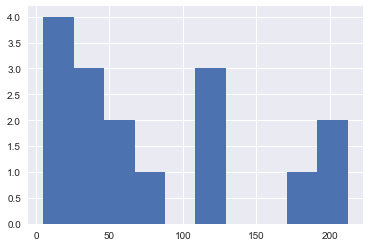

In [216]:
negPnl['volume'].hist()

In [191]:
dataNoneZero = data[data.volume >1]
dataNoneZero

,open,close,high,low,amount,volume,time
date,,,,,,,
2012-01-04,3.26,3.29,3.29,3.26,38558.0,118.0,09:30:00
2012-01-04,3.29,3.29,3.29,3.28,40126.0,122.0,09:31:00
2012-01-04,3.28,3.28,3.29,3.28,62322.0,190.0,09:32:00
2012-01-04,3.28,3.28,3.28,3.28,23747.0,72.0,09:33:00
2012-01-04,3.28,3.28,3.28,3.28,19680.0,60.0,09:34:00
2012-01-04,3.29,3.31,3.31,3.28,124241.0,378.0,09:35:00
2012-01-04,3.29,3.35,3.36,3.29,111684.0,335.0,09:36:00
2012-01-04,3.35,3.34,3.35,3.34,69581.0,208.0,09:37:00
2012-01-04,3.34,3.33,3.34,3.33,43016.0,129.0,09:38:00


In [90]:
datelist = sorted(set(data.index))
Qdf = pd.DataFrame(index=datelist, columns=[stkname], dtype=float)
for date in datelist:
    breakdate = date
    try:
        dataslice = dataNoneZero[dataNoneZero.index == date]
    except:
        Qdf.loc[date] = np.NaN
        continue
    #dataslice = dataNoneZero[dataNoneZero.index == date]
    #dataNoneZero = dataslice.loc[dataslice.volume>0]
    if dataslice.shape[0] >= 60 and dataslice.loc[dataslice['high'] == dataslice['low']].shape[0] < 0.5 \
            * dataslice.shape[0]:  # nonzero volumes should be at least 120
        dataslice['impact'] = np.abs(dataslice['close'] - dataslice['open']) / np.log10(dataslice['volume'])/dataslice['open']
        datanew = dataslice.sort_values(['impact'], ascending=False)
        try:
            q1 = datanew.loc[datanew.volume.cumsum() <= datanew.volume.sum() * 0.3][['amount', 'volume']]
            Qdf.loc[date] = (q1.amount.sum() / q1.volume.sum()) / (datanew.amount.sum() / datanew.volume.sum())
        except ZeroDivisionError:
            Qdf.loc[date] = np.NaN
    else:
        Qdf.loc[date] = np.NaN

c:\python27\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [84]:
filenameHS300Member = 'LZ_CN_STKA_INDEX_HS300MEMBER.h5'
filenameCSI500Member = 'LZ_CN_STKA_INDEX_CSI500MEMBER.h5'

In [89]:
def getMemberList(path,filename):
    df = ff.readh5data(path,filename).iloc[-1]
    return df.loc[df==1].index.tolist()
hs300MemberList = getMemberList(path,filenameHS300Member )
csi500MemberList = getMemberList(path,filenameCSI500Member)
finalList = hs300MemberList+csi500MemberList
finalList

['000002.SZ',
 '000001.SZ',
 '000009.SZ',
 '600606.SH',
 '000008.SZ',
 '000503.SZ',
 '600637.SH',
 '600649.SH',
 '600660.SH',
 '600663.SH',
 '600674.SH',
 '600682.SH',
 '600685.SH',
 '600688.SH',
 '600690.SH',
 '000538.SZ',
 '600804.SH',
 '000559.SZ',
 '600816.SH',
 '600820.SH',
 '000540.SZ',
 '600827.SH',
 '600837.SH',
 '601607.SH',
 '000555.SZ',
 '000568.SZ',
 '600871.SH',
 '600886.SH',
 '600887.SH',
 '600893.SH',
 '600895.SH',
 '600705.SH',
 '600703.SH',
 '600704.SH',
 '600718.SH',
 '000402.SZ',
 '000415.SZ',
 '000423.SZ',
 '600737.SH',
 '600739.SH',
 '600741.SH',
 '000425.SZ',
 '000413.SZ',
 '000623.SZ',
 '000627.SZ',
 '000651.SZ',
 '000630.SZ',
 '000671.SZ',
 '000060.SZ',
 '000686.SZ',
 '600795.SH',
 '000718.SZ',
 '000709.SZ',
 '600060.SH',
 '600066.SH',
 '600061.SH',
 '600068.SH',
 '000625.SZ',
 '000776.SZ',
 '000728.SZ',
 '600089.SH',
 '600074.SH',
 '600085.SH',
 '000738.SZ',
 '000768.SZ',
 '600100.SH',
 '000750.SZ',
 '000793.SZ',
 '000783.SZ',
 '600109.SH',
 '000792.SZ',
 '6001

In [66]:
dataslice

,open,close,high,low,amount,volume,time,impact
date,,,,,,,,
2015-07-09,6.44,6.44,6.44,6.44,2537360.0,3940.0,09:30:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,738024.0,1146.0,09:31:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,530656.0,824.0,09:32:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,475272.0,738.0,09:33:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,81788.0,127.0,09:34:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,153272.0,238.0,09:35:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,228620.0,355.0,09:36:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,83076.0,129.0,09:37:00,0.000000
2015-07-09,6.44,6.44,6.44,6.44,66976.0,104.0,09:38:00,0.000000


In [42]:
dataslice = dataNoneZero[dataNoneZero.index == datelist[6]]

In [56]:
dataslice['impact'] = 100*np.abs(dataslice['close'] - dataslice['open']) / np.log10(dataslice['volume'])/dataslice['open']

c:\python27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,open,close,high,low,amount,volume,time,impact
date,,,,,,,,
2012-01-12,3.45,3.45,3.45,3.44,351004.0,1017.0,09:30:00,0.000000
2012-01-12,3.44,3.43,3.44,3.43,36386.0,106.0,09:31:00,0.143533
2012-01-12,3.43,3.43,3.43,3.43,33957.0,99.0,09:32:00,0.000000
2012-01-12,3.42,3.42,3.42,3.42,684.0,2.0,09:33:00,0.000000
2012-01-12,3.43,3.43,3.43,3.43,12348.0,36.0,09:34:00,0.000000
2012-01-12,3.44,3.44,3.44,3.43,57782.0,168.0,09:35:00,0.000000
2012-01-12,3.44,3.44,3.44,3.43,32678.0,95.0,09:36:00,0.000000
2012-01-12,3.43,3.44,3.44,3.43,26453.0,77.0,09:37:00,0.154544
2012-01-12,3.44,3.44,3.44,3.44,10664.0,31.0,09:38:00,0.000000


In [312]:
fileList = []
for filename in os.listdir(savepath):
    if filename.endswith('.h5') and 'VolQuantileRatio' in filename:
        fileList.append(filename.split('.')[0])
        #print(os.path.join(savepath, file))

In [313]:
fileList

['VolQuantileRatio1000',
 'VolQuantileRatio1500',
 'VolQuantileRatio2000',
 'VolQuantileRatio2500',
 'VolQuantileRatio3000',
 'VolQuantileRatio3200',
 'VolQuantileRatio3400',
 'VolQuantileRatio4000',
 'VolQuantileRatio500']

In [123]:
from multiprocessing import Pool, cpu_count

In [126]:
def calNetIn(stk):
    data = ff.readh5data(savepath,stk+'.h5')[['amount','open','close','time']]
    data['time'] = [datetime.strptime(str(int(time)),'%H%M%S').time() for time in data['time']]

    datelist = sorted(set(data.index))
    Qdf = pd.DataFrame(index = datelist,columns = [stk],dtype=float)
    for date in datelist:
        try:
            dataslice = data[data.index ==date]
            Qdf.loc[date] = (dataslice['amount'] * np.sign(dataslice['close'] - dataslice['open'])).sum()
        except:
            Qdf.loc[date] = np.NaN
    return Qdf   

In [127]:
%lprun -f calNetIn(stkname)

In [20]:
def calSmartMoney(stk):
    data = ff.readh5data(savepath,stk+'.h5')
    data['time'] = [datetime.strptime(str(int(time)),'%H%M%S').time() for time in data['time']]

    datelist = sorted(set(data.index))
    Qdf = pd.DataFrame(index = datelist,columns = [stk],dtype=float)
    for date in datelist:
        dataslice = data[data.index ==date]
        dataNoneZero = dataslice.loc[dataslice.volume>0]
        if len(dataNoneZero) >= 60 and dataNoneZero.loc[dataNoneZero['high']==dataNoneZero['low']].shape[0] < \
        0.5 * dataNoneZero.shape[0]: # nonzero volumes should be at least 120
            dataNoneZero['impact'] = np.abs(dataNoneZero['close'] - dataNoneZero['open']) / dataNoneZero['volume']/dataNoneZero['open']
            datanew = dataNoneZero.sort_values(['impact'],ascending =False)
            q1 = datanew.loc[datanew.volume.cumsum() <= datanew.volume.sum() *0.2]
            Qdf.loc[date] = (q1.amount.sum() / q1.volume.sum()) / (datanew.amount.sum() / datanew.volume.sum())
        else:
            Qdf.loc[date] = np.NaN
    return Qdf

In [21]:
finaldf = pd.DataFrame()
for stk in fileList:
    print stk
    temp = ff.readh5data(path,stk+'.h5')
    finaldf  = pd.concat([finaldf,temp],axis=1)

000001


c:\python27\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


000002
000003
000004
000005
000006
000007
000008
000009
000010


In [167]:
resultlist = []
for filename in os.listdir(savepath):
    if filename.endswith('.h5') and 'OwnfactorNetIn' in filename:
        resultlist.append(filename.split('.')[0])
        #print(os.path.join(savepath, file))
resultlist

['OwnfactorNetIn1000',
 'OwnfactorNetIn2000',
 'OwnfactorNetIn3000',
 'OwnfactorNetIn4000']

In [315]:
resultlist = []
for filename in os.listdir(savepath):
    if filename.endswith('.h5') and 'VolQuantileRatio' in filename:
        resultlist.append(filename.split('.')[0])
        #print(os.path.join(savepath, file))
resultlist

['VolQuantileRatio1000',
 'VolQuantileRatio1500',
 'VolQuantileRatio2000',
 'VolQuantileRatio2500',
 'VolQuantileRatio3000',
 'VolQuantileRatio3200',
 'VolQuantileRatio3400',
 'VolQuantileRatio4000',
 'VolQuantileRatio500']

In [316]:
resultdf = pd.DataFrame()
for stk in resultlist:
    temp = ff.readh5data(savepath,stk+'.'+'h5')
    resultdf = pd.concat([resultdf,temp],axis=1)

In [355]:
ff.saveh5data(resultdf,path,'VolQuantileRatio')

In [356]:
resultdf.tail()

,000993,000995,000996,000997,000998,000999,001696,001896,001979,002001,...,000979,000980,000981,000982,000983,000985,000987,000988,000989,000990
date,,,,,,,,,,,,,,,,,,,,,
2017-09-27,-2.161,NaN,0.363,1.097,1.526,-3.564,NaN,0.277,-0.434,0.550,...,NaN,2.160,-3.530,-1.715,2.327,-1.961,0.647,2.712,-5.974,-0.525
2017-09-28,-7.216,NaN,0.750,0.912,0.656,-3.237,NaN,1.129,-3.834,-0.192,...,NaN,-0.012,-8.805,4.083,-6.314,-4.663,-1.856,-1.218,-0.280,1.026
2017-09-29,-0.929,NaN,-2.188,0.652,1.813,-0.447,NaN,1.466,2.113,0.820,...,NaN,-1.572,4.535,2.688,0.056,0.954,0.867,1.608,5.757,-0.427
2017-10-09,-1.775,NaN,0.030,0.879,-1.914,-0.666,NaN,1.211,1.045,-0.955,...,NaN,1.861,4.306,-4.740,-1.682,2.279,0.092,1.002,-4.778,-2.790
2017-10-10,1.962,NaN,-0.987,2.356,-2.211,0.917,NaN,-2.242,-1.086,-0.283,...,NaN,-3.016,-6.088,-3.801,0.459,-0.190,-0.242,4.094,-1.517,-2.558


In [178]:
resultdf = resultdf.rolling(min_periods=20,window=20,center=False).mean()
resultdf

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,603987,603988,603989,603990,603991,603993,603996,603997,603998,603999
date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
lcap = ff.readh5data(path,filenameFCAP)
codelcap = [x.split('.')[0] for x in lcap.columns]
lcap.columns = codelcap
codedf = resultdf.columns 
finalstklist = list(set(codedf) & set(codelcap))
finalindex = list(set(resultdf.index.tolist()) & set(lcap.index.tolist()))

In [180]:
newdf = (resultdf.loc[finalindex ][finalstklist] / lcap.loc[finalindex][finalstklist]).round(4)

In [181]:
newdf = newdf.sort_index()

In [17]:
Qdf = pd.DataFrame(index = datelist,columns = [stk],dtype=float)
condition1=0
condition2 =0
for date in datelist:
    print date
    dataslice = data[data.index ==date]
    dataNoneZero = dataslice.loc[dataslice.volume>0]
    if len(dataNoneZero) >= 60 and dataNoneZero.loc[dataNoneZero['high']==dataNoneZero['low']].shape[0] < 0.5 * dataNoneZero.shape[0]: # nonzero volumes should be at least 120
        #condition1+=1

        #condition2+=1
        dataNoneZero['impact'] = np.abs(dataNoneZero['close'] - dataNoneZero['open']) / dataNoneZero['volume']/dataNoneZero['open']
        datanew = dataNoneZero.sort_values(['impact'],ascending =False)
        q1 = datanew.loc[datanew.volume.cumsum() <= datanew.volume.sum() *0.2]
        Qdf.loc[date] = (q1.amount.sum() / q1.volume.sum()) / (datanew.amount.sum() / datanew.volume.sum())
        
    else:
        Qdf.loc[date] = np.NaN

2012-01-04 00:00:00
2012-01-05 00:00:00
2012-01-06 00:00:00
2012-01-09 00:00:00
2012-01-10 00:00:00
2012-01-11 00:00:00
2012-01-12 00:00:00
2012-01-13 00:00:00
2012-01-16 00:00:00
2012-01-17 00:00:00
2012-01-18 00:00:00
2012-01-19 00:00:00
2012-01-20 00:00:00
2012-01-30 00:00:00
2012-01-31 00:00:00
2012-02-01 00:00:00
2012-02-02 00:00:00
2012-02-03 00:00:00
2012-02-06 00:00:00
2012-02-07 00:00:00
2012-02-08 00:00:00
2012-02-09 00:00:00
2012-02-10 00:00:00
2012-02-13 00:00:00
2012-02-14 00:00:00
2012-02-15 00:00:00
2012-02-16 00:00:00
2012-02-17 00:00:00
2012-02-20 00:00:00
2012-02-21 00:00:00
2012-02-22 00:00:00
2012-02-23 00:00:00
2012-02-24 00:00:00
2012-02-27 00:00:00
2012-02-28 00:00:00
2012-02-29 00:00:00
2012-03-01 00:00:00
2012-03-02 00:00:00
2012-03-05 00:00:00
2012-03-06 00:00:00
2012-03-07 00:00:00
2012-03-08 00:00:00
2012-03-09 00:00:00
2012-03-12 00:00:00
2012-03-13 00:00:00
2012-03-14 00:00:00
2012-03-15 00:00:00
2012-03-16 00:00:00
2012-03-19 00:00:00
2012-03-20 00:00:00


c:\python27\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2012-04-25 00:00:00
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-05-02 00:00:00
2012-05-03 00:00:00
2012-05-04 00:00:00
2012-05-07 00:00:00
2012-05-08 00:00:00
2012-05-09 00:00:00
2012-05-10 00:00:00
2012-05-11 00:00:00
2012-05-14 00:00:00
2012-05-15 00:00:00
2012-05-16 00:00:00
2012-05-17 00:00:00
2012-05-18 00:00:00
2012-05-21 00:00:00
2012-05-22 00:00:00
2012-05-23 00:00:00
2012-05-24 00:00:00
2012-05-25 00:00:00
2012-05-28 00:00:00
2012-05-29 00:00:00
2012-05-30 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-04 00:00:00
2012-06-05 00:00:00
2012-06-06 00:00:00
2012-06-07 00:00:00
2012-06-08 00:00:00
2012-06-11 00:00:00
2012-06-12 00:00:00
2012-06-13 00:00:00
2012-06-14 00:00:00
2012-06-15 00:00:00
2012-06-18 00:00:00
2012-06-19 00:00:00
2012-06-20 00:00:00
2012-06-21 00:00:00
2012-06-25 00:00:00
2012-06-26 00:00:00
2012-06-27 00:00:00
2012-06-28 00:00:00
2012-06-29 00:00:00
2012-07-02 00:00:00
2012-07-03 00:00:00
2012-07-04 00:00:00
2012-07-05 00:00:00
2012-07-06 00:00:00
